In [28]:
import pandas as pd
import numpy as np
% matplotlib inline
import matplotlib.pyplot as plt

In [48]:
df = pd.read_csv("../data/spi_matches.csv", parse_dates=["date"])

In [49]:
df["result"] = df.apply(
    lambda row: "H" if row.score1 > row.score2 else (
        "D" if row.score1 == row.score2 else "A"), axis=1)


In [50]:
df_prem = df[df.league == "Barclays Premier League"]

In [51]:
df_prem = df_prem[~df_prem.score1.isnull()]

In [52]:
betting = pd.concat([pd.read_csv("../data/1617_results.csv", parse_dates=["Date"], dayfirst=True),
                      pd.read_csv("../data/1718_results.csv", parse_dates=["Date"], dayfirst=True),
                      pd.read_csv("../data/1819_results.csv", parse_dates=["Date"], dayfirst=True)])

In [53]:
team_dict = {"AFC Bournemouth": "Bournemouth",
            "Brighton and Hove Albion": "Brighton",
            "Cardiff City": "Cardiff",
            "Huddersfield Town": "Huddersfield",
            "Hull City": "Hull",
            "Leicester City": "Leicester",
            "Manchester United": "Man United",
            "Manchester City": "Man City",
            "Newcastle United": "Newcastle",
            "Stoke City": "Stoke",
            "Swansea City": "Swansea",
            "Tottenham Hotspur": "Tottenham",
            "West Bromwich Albion": "West Brom",
            "West Ham United": "West Ham",
            "Wolverhampton": "Wolves"}

In [54]:
df_prem.loc[:, "team1"] = df_prem.team1.apply(lambda x: team_dict[x] if x in team_dict.keys() else x)

df_prem.loc[:, "team2"] = df_prem.team2.apply((lambda x: team_dict[x] if x in team_dict.keys() else x))

In [55]:
betting.rename(columns={"HomeTeam": "team1", "AwayTeam": "team2", "Date": "date"}, inplace=True)

In [57]:
merged = pd.merge(betting, df_prem, on=["date", "team1", "team2"])

In [58]:
merged = merged[["team1", "team2", 
                 "BbMxH", "BbMxD", "BbMxA",
                "PSH", "PSD", "PSA", 
                "result", 
                "prob1", "prob2", "probtie"]]

In [59]:
merged.head()

,team1,team2,BbMxH,BbMxD,BbMxA,PSH,PSD,PSA,result,prob1,prob2,probtie
0,Burnley,Swansea,2.55,3.35,3.30,2.47,3.32,3.19,A,0.4482,0.2663,0.2854
1,Crystal Palace,West Brom,2.10,3.40,4.50,2.06,3.29,4.32,A,0.4214,0.2939,0.2847
2,Everton,Tottenham,3.30,3.45,2.50,3.25,3.43,2.37,D,0.3910,0.3401,0.2689
3,Hull,Leicester,4.50,3.60,2.33,4.43,3.55,1.95,H,0.3459,0.3621,0.2921
4,Man City,Sunderland,1.30,6.80,15.00,1.27,6.48,13.15,H,0.8152,0.0525,0.1323


In [73]:
merged["odds1"] = 1 / merged.BbMxH

merged["odds2"] = 1 / merged.BbMxA

merged["oddst"] = 1 / merged.BbMxD

merged["diff1"] = merged.odds1 - merged.prob1
merged["diff2"] = merged.odds2 - merged.prob2
merged["difft"] = merged.oddst - merged.probtie

In [74]:
np.quantile(merged.diff1, 0.95)

0.07534004116073267

In [75]:
np.quantile(merged.diff2, 0.95)

0.07384192307692296

In [76]:
np.quantile(merged.difft, 0.95)

0.036571828410689164

money at end £963.3763121411264
total matches 36
lowest bank £929.2193562480113
highest bank £1627.6531823380183
ROI -1.0%
Percent of matches bet on 3.64


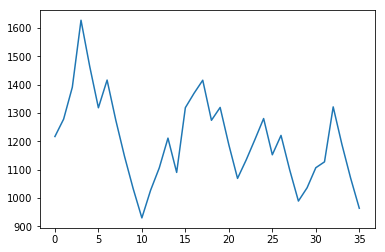

In [89]:
money_history = []
money = 1000
frac = 0.1
total_staked = 0
total_won = 0

for row in merged.itertuples():
#     if row.diff1 >= 0.1:
#         stake = frac * money
#         money -= stake
#         total_staked += stake
#         if row.result == "H":
#             money += stake * row.BbMxH * 0.99
#             total_won += stake * row.BbMxH * 0.99
#         money_history.append(money)
        
    if row.diff2 >= 0.08:
        stake = frac * money
        money -= stake
        total_staked += stake
        if row.result == "A":
            money += stake * row.BbMxA * 0.99
            total_won += stake * row.BbMxA * 0.99
        money_history.append(money)
        
#     if row.difft >= 0.03:
#         stake = frac * money
#         money -= stake
#         total_staked += stake
#         if row.result == "D":
#             money += stake * row.BbMxD * 0.99
#             total_won += stake * row.BbMxD * 0.99
#         money_history.append(money)
        
plt.plot(money_history)
print("money at end £{}".format(money))
print("total matches {}".format(len(money_history)))
print("lowest bank £{}".format(min(money_history)))
print("highest bank £{}".format(max(money_history)))
print("ROI {}%".format(round(100 * ((total_won / total_staked) - 1), 0)))
print("Percent of matches bet on {}".format(round(len(money_history) * 100 / len(df_prem), 2)))